In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [59]:
# POWERS = ['0', '4', '3', '2', '1']
POWERS = ['0', '2']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_EPOCHS = 3
OUTPUT_DIR = "./output_expm1/"

def get_chance(power):
    if power == '0':
        return '100'
    elif power == '4':
        return '93.75'
    elif power == '3':
        return '87.5'
    elif power == '2':
        return '75'
    elif power == '1':
        return '50'
    
def get_power_index(power):
    if power == '0':
        return 0
    elif power == '4':
        return 1
    elif power == '3':
        return 2
    elif power == '2':
        return 1
    elif power == '1':
        return 4
    
SUMMARY_INDEX = pd.Index(['Epoch', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in POWERS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in POWERS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in POWERS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in POWERS]
INDEX_TIME_COL = ['Index_time_epoch{}_{}%'.format(str(i+1), get_chance(p)) for p in POWERS for i in range(NUMBER_OF_EPOCHS)]
QUERY_TIME_COL = ['Query_time_epoch{}_{}%'.format(str(i+1), get_chance(p)) for p in POWERS for i in range(NUMBER_OF_EPOCHS)]

FREQ_TABLES_X = ['DocList_length_' + get_chance(p) + '%' for p in POWERS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in POWERS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in POWERS]

# Run Experiment  One and Read in Results

* Use one-word term
* Each term has a 100% chance or 75% chance to be included in the index or fingerprint

In [3]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
#     for p in POWERS:
#         runSketchTweets("SketchingTweet-v1", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_EPOCHS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [4]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_power, similarity_threshold, n, output_dir):
    for epoch in range (1, n+1):
        os.system("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_power, similarity_threshold, epoch, output_dir))

In [5]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(POWERS)
    termfreq = [0] * len(POWERS)
    query_result = [0] * len(POWERS)
    query_similarity = [0] * len(POWERS)
    query_lookups = [0] * len(POWERS)
    index_time = [[0 for j in range(NUMBER_OF_EPOCHS)] for i in range(len(POWERS))]
    query_time = [[0 for j in range(NUMBER_OF_EPOCHS)] for i in range(len(POWERS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_(\d+)_s_([\.\d]+)_(.+).csv', file)  
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            power = filename.group(4)

            if name == "summary":    
                for p in POWERS:
                    if power == p:
                        summary[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in POWERS:
                    if power == p:
                        termfreq[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in POWERS:
                    if power == p:
                        query_result[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_similarity":
                for p in POWERS:
                    if power == p:
                        query_similarity[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in POWERS:
                    if power == p:
                        query_lookups[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                epoch = filename.group(1)
                for p in POWERS:
                    if power == p:
                        for i in range(0,NUMBER_OF_EPOCHS):
                            if epoch == str(i+1):
                                index_time[get_power_index(power)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                epoch = filename.group(1)
                for p in POWERS:
                    if power == p:
                        for i in range(0,NUMBER_OF_EPOCHS):
                            if epoch == str(i+1):
                                query_time[get_power_index(power)][i] = pd.read_csv(directory + "/" + file, header=None)
                  

    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

In [6]:
results = run_expm1() 

# Process Results

## Index size comparison

In [10]:
summary = results['summary']
summary

,Summary_100%,Summary_75%
Epoch,1,1
Chance,100.0%,75.0%
Index time unit,1000,1000
Query time unit,1000,1000
Similarity threshold,0.500000,0.500000
Query counts,4638,4638
Indexed tweet counts,41176,41176
Index size,86526,65756


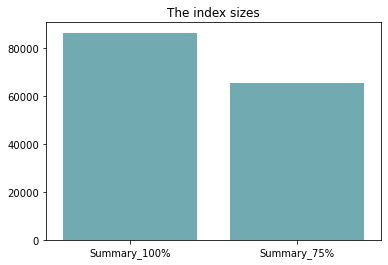

Summary_100%    86526
Summary_75%     65756
Name: Index size, dtype: object

In [13]:
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes) 
    layer = sns.barplot(x=data.index, y=data.to_list(), color="#66B3BA")
    plt.title(title)
    plt.show()

compare_index_size(summary.loc['Index size'], "The index sizes")
summary.loc['Index size']

## Documnet list length comparison

In [24]:
freq_tables = results['termfreq']
freq_tables

[                         1
 0                         
 trickster                1
 losheim                  1
 moreebfbaldubyayawho     1
 ngrmektiratatrk          1
 52ms                     1
 ...                    ...
 el                    2355
 en                    2738
 la                    3455
 que                   4928
 de                    7104
 
 [86526 rows x 1 columns],
                          1
 0                         
 levaria                  1
 trickster                1
 losheim                  1
 moreebfbaldubyayawho     1
 ngrmektiratatrk          1
 ...                    ...
 bestfanarmy           1588
 el                    2355
 la                    3455
 que                   4928
 de                    7104
 
 [65756 rows x 1 columns]]

In [22]:
doclist_lengths = [table.value_counts() for table in freq_tables]
doclist_lengths

[1   
 1       55048
 2       11668
 3        5116
 4        2969
 5        1944
         ...  
 280         1
 286         1
 295         1
 297         1
 7104        1
 Length: 353, dtype: int64,
 1   
 1       42343
 2        8681
 3        3803
 4        2186
 5        1429
         ...  
 246         1
 244         1
 233         1
 231         1
 7104        1
 Length: 318, dtype: int64]

In [28]:
lengths = [len(np.array(table.squeeze())) for table in freq_tables]
lengths

[86526, 65756]

The average document list length: 
[4.96099438319118, 5.000714763671756]


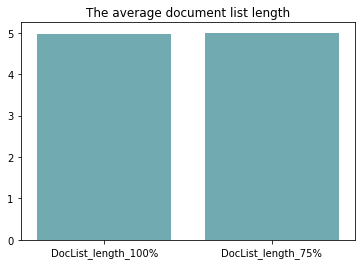

In [37]:
def compare_doclist_len(freq_tables, title):
    lengths = [np.array(table.squeeze()) for table in freq_tables]
    avgs = [np.average(l) for l in lengths]
    medians = [np.median(l) for l in lengths]
    print('The average document list length: ')
    print(avgs)
    layer = sns.barplot(x=FREQ_TABLES_X, y=avgs, color="#66B3BA")
    plt.title(title)
    plt.show()

compare_doclist_len(freq_tables, "The average document list length")

## Query Recall
what we searched correctly / what are truely similar

In [39]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_75%,Similarity_100%,Similarity_75%,Lookups_100%,Lookups_75%
0,-1,-1,0.0,0.00000,-1,-1
1,-1,39509,0.0,0.50000,-1,1064
2,-1,-1,0.0,0.00000,-1,-1
3,-1,-1,0.0,0.00000,-1,-1
4,29741,12539,0.5,0.54545,44760,97185
...,...,...,...,...,...,...
4633,-1,-1,0.0,0.00000,-1,-1
4634,-1,-1,0.0,0.00000,-1,-1
4635,-1,-1,0.0,0.00000,-1,-1
4636,-1,-1,0.0,0.00000,-1,-1


In [42]:
is_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[is_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

,Result_100%,Result_75%,Similarity_100%,Similarity_75%,Lookups_100%,Lookups_75%
4,29741,12539,0.50000,0.54545,44760,97185
13,27190,27190,0.50000,0.60000,4332,3180
19,30252,39853,0.54545,0.50000,31504,2768
21,3775,3775,0.55556,0.71429,14463,6454
22,38576,40016,0.50000,0.54545,10892,3487
...,...,...,...,...,...,...
4618,41115,41115,0.50000,0.60000,132,110
4619,30963,30963,1.00000,1.00000,10170,1788
4627,41111,41111,0.95000,0.94444,440,396
4628,19582,19582,1.00000,1.00000,864,135


In [80]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('The number of true similar tweets that we found: ')
num_correct_searches

The number of true similar tweets that we found: 


[1141, 698]

Using 100% of terms, we can find 100.0% true similar tweets
Using 75% of terms, we can find 61.17% true similar tweets


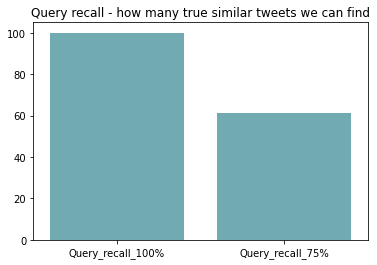

In [58]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=QUERY_RECALL_X, y=recalls, color="#66B3BA")
    plt.title(title)
    plt.show()

recalls = []
for i in range(len(num_correct_searches)):
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = QUERY_RECALL_X[i][13:]
    print('Using {} of terms, we can find {}% true similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - how many true similar tweets we can find')

## Query Precision
what we searched correctly / what are think are similar

In [67]:
is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
predict_similar = query_result_similarity_lookup[is_predict_similar]
num_predict_similar = predict_similar.shape[0]
predict_similar

num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

[1141, 1619]

Using 100% of terms, 100.0% tweets that we found similar are truely similar tweets
Using 75% of terms, 43.11% tweets that we found similar are truely similar tweets


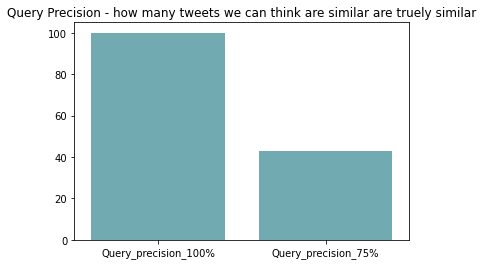

In [75]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=QUERY_PRECISION_X, y=precisions, color="#66B3BA")
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_correct_searches)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = QUERY_PRECISION_X[i][16:]
    print('Using {} of terms, {}% tweets that we found similar are truely similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - how many tweets we can think are similar are truely similar')

## Number of lookups in the correct searches

In [88]:
# is_less_search = correct_search['Lookups_100%'] > correct_search['Lookups_75%']
# less_search = correct_search[is_less_search]
# num_less_search = less_search.shape[0]
# less_search

num_less_search_lst = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_search[QUERY_LOOKUPS_COL[0]] > correct_search[QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        num_less_search_lst.append(less_search.shape[0])
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
num_less_search_lst

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[523]

In [19]:
proportion = round((num_less_search / num_correct_search) * 100, 2)
print('Using 75% terms, {}% tweets need less lookups before correctly finding the true similar tweets'.format(proportion))

Using 75% terms, 74.93% tweets need less lookups before correctly finding the true similar tweets


In [20]:
avg_lookups_100 = np.average(np.array(correct_search['num_of_lookups_100%']))
avg_lookups_75 = np.average(np.array(correct_search['num_of_lookups_75%']))
reduce = round(((avg_lookups_100 - avg_lookups_75) / avg_lookups_100) * 100, 2)
print('Using 75% terms, {}% less lookups are needed for correctly finding the true similar tweets'.format(reduce))

Using 75% terms, 28.99% less lookups are needed for correctly finding the true similar tweets


## Index time comparison

In [21]:
index_time

,index_time_100%_epoch1,index_time_100%_epoch2,index_time_100%_epoch3,index_time_75%_epoch1,index_time_75%_epoch2,index_time_75%_epoch3
0,11.7285,14.1650,12.0094,15.2433,15.4575,14.9313
1,4.9307,5.6155,5.8612,5.3093,5.5029,5.5420
2,4.6102,5.4538,5.3014,5.0554,5.6390,5.4649
3,8.6907,10.9729,8.1911,8.7911,7.4324,7.7289
4,4.2128,4.2355,3.5632,4.0311,3.9452,5.6867
5,3.4715,4.4716,4.1374,4.5456,4.7302,5.5109
6,3.2211,3.9046,3.6054,4.3723,4.2469,5.1900
7,3.2597,3.4949,3.4877,3.5027,4.0097,4.1381
8,3.0226,3.5304,3.5657,3.5526,3.6455,4.1182
9,4.4217,4.6904,4.2821,5.1175,4.6594,4.6652


In [22]:
index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

index_time_avgs2 
print('Using 100% terms, the average time for indexing 1000 tweets is {} milliseconds'.format(index_time_avgs2[0]))
print('Using 75% terms, the average time for indexing 1000 tweets is {} milliseconds'.format(index_time_avgs2[1]))

Using 100% terms, the average time for indexing 1000 tweets is 4.7742 milliseconds
Using 75% terms, the average time for indexing 1000 tweets is 4.9414 milliseconds


## Query time comparison

In [23]:
query_time

,query_time_100%_epoch1,query_time_100%_epoch2,query_time_100%_epoch3,query_time_75%_epoch1,query_time_75%_epoch2,query_time_75%_epoch3
0,4.4853,4.5160,4.3103,1.6627,1.5941,1.9311
1,289.3204,273.9674,269.1538,259.3026,264.8178,247.3292
2,169.1755,172.0283,172.8361,110.1270,114.7253,117.2401
3,165.1126,179.0841,165.0008,110.9941,120.8176,115.9694
4,170.6251,179.2199,165.6893,105.8311,120.0116,114.7786


In [24]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

query_time_avgs2 
print('Using 100% terms, the average time for querying 1000 tweets is {} milliseconds'.format(query_time_avgs2[0]))
print('Using 75% terms, the average time for querying 1000 tweets is {} milliseconds'.format(query_time_avgs2[1]))

Using 100% terms, the average time for querying 1000 tweets is 158.9683 milliseconds
Using 75% terms, the average time for querying 1000 tweets is 120.4755 milliseconds
